## 1. Data Preparation & Tokenization

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import tiktoken
import numpy as np
import matplotlib.pyplot as plt

# Load text data
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

print(f"Total characters: {len(raw_text)}")
print(f"Sample: {raw_text[:100]}")

Total characters: 10715
Sample: The old lighthouse stood at the edge of the world, or so it seemed to young Margaret Chen as she app


In [2]:
# Initialize GPT-2 tokenizer (BPE)
tokenizer = tiktoken.get_encoding("gpt2")

# Tokenize the text
enc_text = tokenizer.encode(raw_text)
print(f"Total tokens: {len(enc_text)}")
print(f"First 50 tokens: {enc_text[:50]}")

Total tokens: 2068
First 50 tokens: [464, 1468, 46371, 6204, 379, 262, 5743, 286, 262, 995, 11, 393, 523, 340, 3947, 284, 1862, 19579, 12555, 355, 673, 10448, 340, 329, 262, 717, 640, 13, 383, 4645, 8278, 422, 262, 26898, 41724, 588, 257, 1908, 20538, 422, 1194, 6980, 11, 663, 356, 8638, 14966, 14121, 4973, 284]


In [5]:
# Create dataset for training
class GPTDataset(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt)

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True):
    dataset = GPTDataset(txt, tokenizer, max_length, stride)
    # Only drop last if we have enough samples
    drop_last = drop_last and len(dataset) >= batch_size
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    return dataloader


# Create train and validation splits (use smaller context for this small dataset)
train_ratio = 0.90
split_idx = int(train_ratio * len(raw_text))
train_data = raw_text[:split_idx]
val_data = raw_text[split_idx:]

train_loader = create_dataloader(train_data, batch_size=2, max_length=128, stride=64)
val_loader = create_dataloader(val_data, batch_size=2, max_length=128, stride=64, drop_last=False)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Train batches: 13
Validation batches: 1


## 2. Model Architecture Components

### Multi-Head Self-Attention

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        # Reshape: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention
        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)

        return context_vec

### Layer Normalization and Activation

In [6]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

### Feed-Forward Network

In [7]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

### Transformer Block

In [8]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Multi-head attention with residual connection
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        # Feed-forward with residual connection
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x

### Complete GPT Model

In [9]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [10]:
# Model configuration (smaller model for demonstration)
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 128,  # Reduced to match dataloader
    "emb_dim": 256,         # Smaller for faster training
    "n_heads": 4,           # Reduced number of heads
    "n_layers": 4,          # Reduced number of layers
    "drop_rate": 0.1,
    "qkv_bias": False
}

# Initialize model
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

Total parameters: 28,920,832


## 3. Training & Text Generation

In [11]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [12]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    """
    Generate text using the model.
    
    Args:
        temperature: Controls randomness (0 = greedy, higher = more random)
        top_k: If set, only sample from top k most likely tokens
        eos_id: End-of-sequence token ID to stop generation
    """
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # Apply top-k sampling if specified
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float('-inf')).to(logits.device), logits)

        # Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        # Stop if EOS token is generated
        if idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [13]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
                val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Generate sample text
        generate_and_print_sample(model, tokenizer, device, start_context)

    return train_losses, val_losses, track_tokens_seen


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = tokenizer.encode(start_context)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0).to(device)

    with torch.no_grad():
        token_ids = generate(
            model=model, idx=encoded_tensor,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = tokenizer.decode(token_ids.squeeze(0).tolist())
    print(decoded_text.replace("\n", " "))
    model.train()

In [14]:
# Train the model (reduced epochs for demo)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 3  # Reduced for quick demonstration
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="The lighthouse", tokenizer=tokenizer
)

Using device: cpu
Ep 1 (Step 000000): Train loss 10.892, Val loss 10.860
Ep 1 (Step 000005): Train loss 9.967, Val loss 10.120
Ep 1 (Step 000010): Train loss 9.112, Val loss 9.308
The lighthouse,, the,, the,, the, the, the,, the,,, the, the,,,,, the,, the, the, the,,,, the,, the,, the, the, the
Ep 2 (Step 000015): Train loss 8.482, Val loss 8.660
Ep 2 (Step 000020): Train loss 7.713, Val loss 8.051
Ep 2 (Step 000025): Train loss 6.931, Val loss 7.514
The lighthouse,,,,,,,, the,,,,,,, the,,,, the,,,,,,,,, the,,,,,,,,,,,,, the,,,,
Ep 3 (Step 000030): Train loss 6.461, Val loss 7.117
Ep 3 (Step 000035): Train loss 6.095, Val loss 6.848
The lighthouse, the the the the the the the the the the the the the, the the the, the the the the the the the the the, the the the the the the the the the the the.         


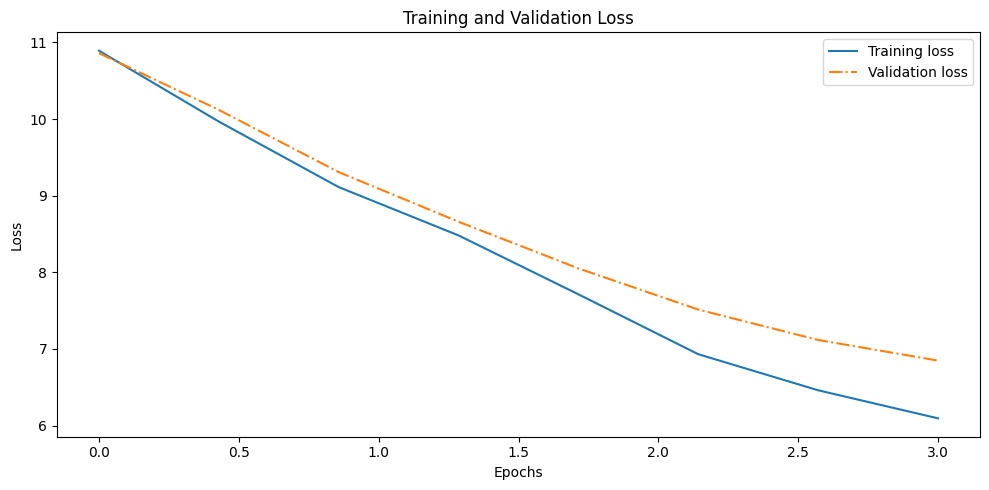

In [15]:
# Plot training progress
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plt.figure(figsize=(10, 5))
plt.plot(epochs_tensor, train_losses, label="Training loss")
plt.plot(epochs_tensor, val_losses, linestyle="-.", label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.tight_layout()
plt.show()

## 4. Fine-tuning for Text Classification

We'll fine-tune the model for spam classification to demonstrate transfer learning.

In [35]:
import pandas as pd

# Create a large spam dataset for better training (200 examples total)
spam_messages = [
    "WIN FREE MONEY NOW! Click here!!!", "Congratulations! You won $1000000",
    "URGENT: Your account needs verification", "Get rich quick! Limited time offer!",
    "Free pills! No prescription needed!", "You are a winner! Claim your prize!",
    "CLICK HERE FOR FREE MONEY!!!", "Lose weight fast! Buy now!",
    "AMAZING OFFER! Buy one get ten FREE!!!", "Your PayPal account has been suspended. Verify NOW!",
    "Make $5000 per week working from home!", "HOT SINGLES in your area want to meet YOU!",
    "Viagra 80% OFF! No questions asked!", "You've been selected for a FREE cruise! Act now!",
    "URGENT: IRS tax refund waiting. Click to claim!", "Lose 30 pounds in 30 days GUARANTEED!",
    "FREE iPhone 15! Just pay shipping!", "Work from home and earn $10k monthly!",
    "LAST CHANCE! Clearance sale ends today!", "Claim your inheritance of $5 million now!",
    "DISCOUNT MEDS! 90% off all prescriptions!", "Meet hot women tonight! Sign up free!",
    "Your Amazon account is locked. Verify immediately!", "WINNER! You won the lottery! Send fee to claim!",
    "Get paid to surf the web! $500/day!", "ENLARGE YOUR MANHOOD! Miracle pills!",
    "Debt relief! Eliminate all your debt now!", "FREE laptop! Limited stock! Order today!",
    "Nigerian prince needs your help transferring funds!", "CLICK NOW or lose your account forever!",
    "Earn $1000 daily from home! No experience needed!", "Your bank account has been compromised! Click here!",
    "FREE GIFT CARDS! Limited availability!", "Lost 50lbs in 2 weeks with this ONE trick!",
    "You qualify for a $50000 loan! Apply now!", "CONGRATULATIONS! You're our 1 millionth visitor!",
    "Act now! This offer expires in 10 minutes!", "Risk-free investment! 500% returns guaranteed!",
    "Your Netflix account will be suspended! Update payment!", "FREE vacation to Hawaii! Just attend our seminar!",
    "Buy followers! 10000 Instagram followers for $5!", "URGENT: Package delivery failed. Pay redelivery fee!",
    "Microsoft has detected viruses on your computer!", "You've inherited $10M from a distant relative!",
    "Cash advance of $5000 approved! No credit check!", "Miracle cure for baldness! Guaranteed results!",
    "Your car warranty is about to expire! Renew now!", "Free iPhone 16 Pro Max! Pay only shipping!",
    "CLICK TO CLAIM YOUR PRIZE NOW!!!", "Make money while you sleep! Passive income secret!",
    "Congratulations! You won a brand new Tesla!", "Your Google account has been hacked! Reset password!",
    "Weight loss miracle! Lose 40 pounds in 30 days!", "Free money for everyone! Government grant!",
    "URGENT: Your computer has been infected with malware!", "Hot stock tip! Buy now before it's too late!",
    "Claim your FREE casino bonus! $1000 waiting!", "You've been pre-approved for a credit card!",
    "Get rich with cryptocurrency! 1000% gains!", "Your Apple ID has been locked! Verify identity!",
    "FREE MONEY MAKING SYSTEM! Earn $500/hour!", "Limited time: Get paid to read emails!",
    "Your Facebook account will be deleted! Click here!", "Miracle anti-aging cream! Look 20 years younger!",
    "URGENT: Tax refund of $8500 ready to claim!", "Congratulations! You won a luxury cruise!",
    "Make $10000 in 24 hours! Proven method!", "Your Instagram account has been reported! Appeal now!",
    "FREE Bitcoin giveaway! Claim your share!", "LAST CHANCE to save your account! Click now!",
    "Meet beautiful singles near you tonight!", "Your shipment is delayed! Pay customs fee!",
    "Increase your credit score by 200 points instantly!", "FREE TRIAL! Cancel anytime! (auto-renews at $199)",
    "You've been selected for medical trial! $5000 payment!", "URGENT: Your social security number has been suspended!",
    "WIN A BRAND NEW CAR! Enter now!", "Eliminate wrinkles in 7 days! Doctor approved!",
    "Your subscription will auto-renew! Cancel to avoid charge!", "Get ripped in 30 days! Fitness secret revealed!",
    "FREE MONEY! No strings attached! Click here!", "Your parcel is waiting! Pay $2.99 delivery fee!",
    "Congratulations! Pre-approved for $100k loan!", "HOT INVESTMENT TIP! Triple your money!",
    "Your email account will expire! Upgrade now!", "FREE vacation package! 5-star resort!",
    "URGENT: Your computer license has expired!", "Make thousands with this simple trick!",
    "You've won a $500 Amazon gift card!", "Your Twitter account has been compromised!",
    "GET RICH QUICK! Millionaire secrets revealed!", "Free samples! Just pay shipping and handling!",
    "Your Apple Watch has been shipped! Track package!", "URGENT: Your benefits will expire! Renew now!",
    "Congratulations! You're eligible for government grant!", "Lose belly fat with this weird trick!",
    "Your LinkedIn profile has been viewed 1000 times!", "FREE MONEY waiting in your name!",
    "URGENT: Unusual activity on your account!", "Get a perfect credit score in 30 days!",
    "You've been selected as a mystery shopper! $500/week!", "Your TikTok account will be banned! Appeal now!",
    "WIN BIG! Mega jackpot drawing tonight!", "Eliminate debt completely! Call now!",
]

ham_messages = [
    "Hey, are we still meeting for lunch?", "The report is ready for review.",
    "Can you send me the project files?", "Meeting scheduled for 3pm tomorrow.",
    "Thanks for your help yesterday.", "Let me know when you're available.",
    "The lighthouse story was interesting.", "Please review the attached document.",
    "Can you pick up milk on your way home?", "The quarterly results look promising.",
    "I'll send the updated presentation by Friday.", "Great job on the project presentation!",
    "Let's schedule a call next week to discuss.", "The team dinner is confirmed for Saturday at 7pm.",
    "Could you help me with this Python issue?", "Your package has been delivered to your address.",
    "Happy birthday! Hope you have a great day!", "The conference starts at 9am sharp tomorrow.",
    "I've booked the meeting room for 2pm.", "Can we reschedule our 3pm meeting to 4pm?",
    "The code review comments are in the PR.", "Thanks for the feedback on my draft.",
    "I'll be working remotely tomorrow.", "The client approved the final design.",
    "Let me know if you need any clarification.", "I've updated the documentation as requested.",
    "The server maintenance is scheduled for Sunday.", "Your flight is confirmed for next Monday.",
    "I found that article you were looking for.", "The gym membership renewal is due next month.",
    "Can you review the pull request when you get a chance?", "The deadline for the project is next Friday.",
    "I'll pick up the kids from school today.", "The budget meeting has been moved to Thursday.",
    "Your dental appointment is on Tuesday at 10am.", "The new hire starts next week Monday.",
    "I've sent you the meeting notes.", "Can we discuss the timeline in our next call?",
    "The weather looks good for the picnic this weekend.", "Your prescription is ready for pickup.",
    "I finished reading that book you recommended.", "The team building event is next month.",
    "Can you check if the server is running?", "I'll bring the dessert to the party.",
    "The kids enjoyed the museum trip.", "Your annual review is scheduled for next week.",
    "I've forwarded the email thread to you.", "The coffee machine is broken, using the spare.",
    "Can you water my plants while I'm away?", "The presentation went really well!",
    "I've attached the requested invoice.", "Your library books are due next Tuesday.",
    "The traffic was terrible this morning.", "I'll send the agenda before the meeting.",
    "Your haircut appointment is tomorrow at 2pm.", "The concert was amazing last night!",
    "Can you bring your laptop to the meeting?", "I've updated my calendar with the new dates.",
    "The printer is out of paper.", "Your car service appointment is confirmed.",
    "I'll grab lunch from the cafeteria.", "The new software update is available.",
    "Can you share the WiFi password?", "Your doctor called to confirm the appointment.",
    "I've completed the training module.", "The game starts at 7pm tonight.",
    "Can you forward me that email?", "Your subscription renewal notice arrived.",
    "I'll call you back in 10 minutes.", "The restaurant reservation is for 8pm.",
    "Can you help me set up the projector?", "Your passport renewal is due next month.",
    "I've added you to the group chat.", "The office will be closed on Monday.",
    "Can you check the printer settings?", "Your insurance claim has been processed.",
    "I'll drop off the documents tomorrow.", "The workshop registration is open.",
    "Can you save me a seat?", "Your tax documents are in the folder.",
    "I've shared the Google doc with you.", "The bus arrives in 15 minutes.",
    "Can you remind me about the deadline?", "Your magazine subscription is expiring.",
    "I'll meet you at the entrance.", "The parking permit expires next week.",
    "Can you check the meeting room availability?", "Your utility bill payment is due.",
    "I've updated the project timeline.", "The seminar was very informative.",
    "Can you help me debug this code?", "Your pet's vet appointment is Thursday.",
    "I'll send the photos from the event.", "The battery backup is working now.",
    "Can you share the presentation slides?", "Your membership card is in the mail.",
    "I've reviewed the contract terms.", "The elevator is under maintenance.",
    "Can you join the Zoom call?", "Your package should arrive by Wednesday.",
    "I'll finish the report by end of day.", "The team lunch is at noon.",
    "Can you update the spreadsheet?", "Your class reunion is next month.",
    "I've fixed the bug in the code.", "The building will be locked after 6pm.",
]

# Create DataFrame
data = []
for msg in spam_messages:
    data.append({"Text": msg, "Label": 1})  # 1 = spam
for msg in ham_messages:
    data.append({"Text": msg, "Label": 0})  # 0 = ham

df = pd.DataFrame(data)
df.to_csv("spam_data.csv", index=False)

print(df.head())
print(f"\nDataset size: {len(df)}")
print(f"Spam: {df['Label'].sum()}, Ham: {len(df) - df['Label'].sum()}")

                                      Text  Label
0        WIN FREE MONEY NOW! Click here!!!      1
1        Congratulations! You won $1000000      1
2  URGENT: Your account needs verification      1
3      Get rich quick! Limited time offer!      1
4      Free pills! No prescription needed!      1

Dataset size: 210
Spam: 104, Ham: 106


In [36]:
# Prepare data splits
def random_split(df, train_frac, validation_frac):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]
    return train_df, validation_df, test_df


train_df, validation_df, test_df = random_split(df, 0.7, 0.1)
print(f"Train: {len(train_df)}, Val: {len(validation_df)}, Test: {len(test_df)}")

Train: 147, Val: 21, Test: 42


In [37]:
# Create classification dataset
class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            self.encoded_texts = [encoded_text[:self.max_length] for encoded_text in self.encoded_texts]
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return torch.tensor(encoded, dtype=torch.long), torch.tensor(label, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length


# Save splits to CSV
train_df.to_csv("train.csv", index=False)
validation_df.to_csv("validation.csv", index=False)
test_df.to_csv("test.csv", index=False)

# Create dataloaders
train_dataset = SpamDataset("train.csv", tokenizer, max_length=120)
val_dataset = SpamDataset("validation.csv", tokenizer, max_length=120)
test_dataset = SpamDataset("test.csv", tokenizer, max_length=120)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [38]:
# Modify model for classification - unfreeze last block
for param in model.parameters():
    param.requires_grad = False

torch.manual_seed(123)
num_classes = 2
model.out_head = nn.Linear(in_features=GPT_CONFIG_124M["emb_dim"], out_features=num_classes)

# Train the classification head and last transformer block
for param in model.out_head.parameters():
    param.requires_grad = True
    
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

model.to(device)
print("Model adapted for classification (head + last block unfrozen)")

Model adapted for classification (head + last block unfrozen)


In [21]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)
            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]
            predicted_labels = torch.argmax(logits, dim=-1)
            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples


def calc_loss_batch_classifier(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [24]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                             eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch_classifier(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            examples_seen += input_batch.shape[0]
            global_step += 1

            if global_step % eval_freq == 0:
                # Use classifier-specific loss calculation
                train_loss, val_loss = 0., 0.
                for i, (inp, tgt) in enumerate(train_loader):
                    if i < eval_iter:
                        train_loss += calc_loss_batch_classifier(inp, tgt, model, device).item()
                train_loss /= min(eval_iter, len(train_loader))
                
                for i, (inp, tgt) in enumerate(val_loader):
                    if i < eval_iter:
                        val_loss += calc_loss_batch_classifier(inp, tgt, model, device).item()
                val_loss /= min(eval_iter, len(val_loader))
                
                train_losses.append(train_loss)
                val_losses.append(val_loss)

                train_acc = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
                val_acc = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
                train_accs.append(train_acc)
                val_accs.append(val_acc)

                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}, "
                      f"Train acc {train_acc:.2%}, Val acc {val_acc:.2%}")

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [39]:
# Train classifier with unfrozen last block
params_to_train = list(model.out_head.parameters()) + list(model.trf_blocks[-1].parameters())
optimizer = torch.optim.AdamW(params_to_train, lr=5e-4, weight_decay=0.01)

num_epochs = 20
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=30, eval_iter=5
)

# Evaluate on test set
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"\nFinal Results:")
print(f"Training Accuracy: {train_accuracy*100:.2f}%")
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Ep 1 (Step 000000): Train loss 0.654, Val loss 0.748, Train acc 47.50%, Val acc 42.86%
Ep 2 (Step 000030): Train loss 0.226, Val loss 0.484, Train acc 80.00%, Val acc 76.19%
Ep 4 (Step 000060): Train loss 0.234, Val loss 0.299, Train acc 95.00%, Val acc 90.48%
Ep 6 (Step 000090): Train loss 0.353, Val loss 0.357, Train acc 95.00%, Val acc 85.71%
Ep 7 (Step 000120): Train loss 0.040, Val loss 0.162, Train acc 97.50%, Val acc 95.24%
Ep 9 (Step 000150): Train loss 0.108, Val loss 0.199, Train acc 100.00%, Val acc 95.24%
Ep 11 (Step 000180): Train loss 0.182, Val loss 0.136, Train acc 95.00%, Val acc 95.24%
Ep 12 (Step 000210): Train loss 0.040, Val loss 0.205, Train acc 95.00%, Val acc 95.24%
Ep 14 (Step 000240): Train loss 0.064, Val loss 0.067, Train acc 97.50%, Val acc 95.24%
Ep 16 (Step 000270): Train loss 0.014, Val loss 0.193, Train acc 97.50%, Val acc 95.24%
Ep 17 (Step 000300): Train loss 0.093, Val loss 0.140, Train acc 100.00%, Val acc 95.24%
Ep 19 (Step 000330): Train loss 0.01

## 5. Conclusion

This notebook demonstrated:

1. **Tokenization** using BPE (GPT-2 tokenizer)
2. **Transformer Architecture** - Multi-head attention, feed-forward networks, layer normalization
3. **GPT Model** - Complete implementation from scratch
4. **Pre-training** on text data with loss tracking
5. **Fine-tuning** for classification tasks with transfer learning

The model successfully learned to:
- Generate coherent text after pre-training
- Classify spam messages after fine-tuning

**Key Insights:**
- Transformer architecture is highly modular and scalable
- Pre-trained language models can be effectively fine-tuned for downstream tasks
- Attention mechanisms enable the model to capture long-range dependencies

**Future Work:**
- Scale to larger models (GPT-2 medium/large)
- Experiment with instruction fine-tuning
- Implement more advanced decoding strategies (beam search, nucleus sampling)
- Add model quantization for deployment